In [1]:
import torch
from torch.cuda import is_available
from torch.optim import Adam
from torch.nn import MSELoss, BCELoss
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from utils import ims, imshow
from conv3d import Conv3D, Check

### The outputs after each layer: 
`dim = (batch_size, channels, frames, height, width)`
* Conv3d layer 1: `(1, 16, 1, 160, 120)`

* Conv3d layer 2: `(1, 32, 1, 160, 120)`

* Conv3d layer 3: `(1, 16, 1, 160, 120)`

* Conv3d layer 4: `(1, 1, 1, 160, 120)`


In [2]:
torch.cuda.is_available()

True

In [3]:
model = Conv3D()
device = 'cuda:0'
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchN

In [4]:
from pytictoc import TicToc
t = TicToc()

In [5]:
t.tic()
dataset = Check(5, angle=0, keyposes=[4,5])
t.toc()

Elapsed time is 52.008884 seconds.


In [6]:
len(dataset)

65

In [7]:
train_dl = DataLoader(dataset,batch_size=1,shuffle=True)

In [8]:
#Loss
criterion = MSELoss()
#Optimizer
optimizer = Adam(model.parameters(), lr=0.001)

## Training

In [9]:
# from tqdm import tqdm

In [10]:
#Epochs
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images,y in train_dl:
        images,y = images.to(device), y.to(device)
        # print('images.shape',images.shape)
        optimizer.zero_grad()

        out = model(images)

        loss = criterion(out.view(out.shape[2],out.shape[3],out.shape[4]), torch.tile(y,(out.shape[2],1,1)))
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
          
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.248170
Epoch: 2 	Training Loss: 0.134953
Epoch: 3 	Training Loss: 0.122323
Epoch: 4 	Training Loss: 0.083626
Epoch: 5 	Training Loss: 0.067179
Epoch: 6 	Training Loss: 0.064419
Epoch: 7 	Training Loss: 0.061555
Epoch: 8 	Training Loss: 0.057453
Epoch: 9 	Training Loss: 0.049831
Epoch: 10 	Training Loss: 0.051089
Epoch: 11 	Training Loss: 0.053447
Epoch: 12 	Training Loss: 0.048257
Epoch: 13 	Training Loss: 0.050685
Epoch: 14 	Training Loss: 0.042960
Epoch: 15 	Training Loss: 0.043685


## Check
`240 images (80 samples from 15 experiments, 3 frames each)`

In [11]:
def ims(model_out,actual):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4))
    axes[0].imshow(model_out,cmap='gray',vmin=0,vmax=1)
    axes[0].set_title('Model')
    axes[1].imshow(actual,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Average')
    plt.show()


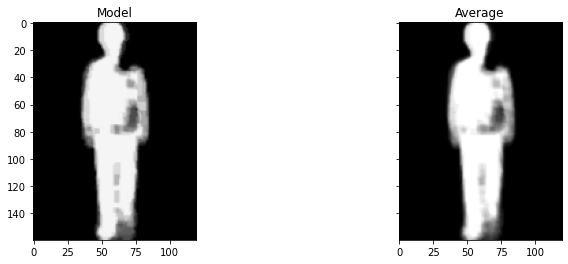

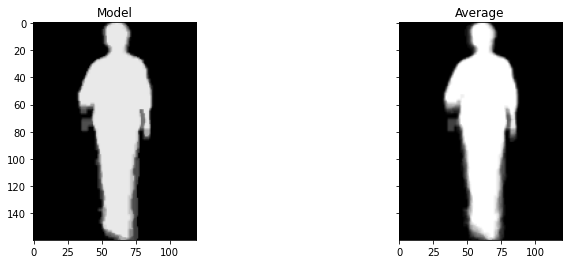

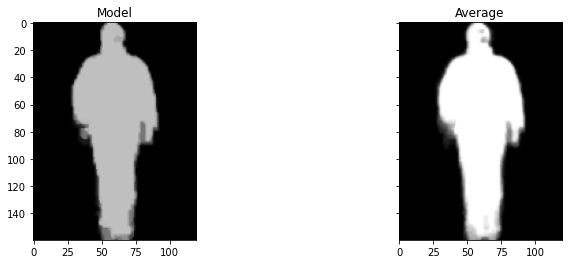

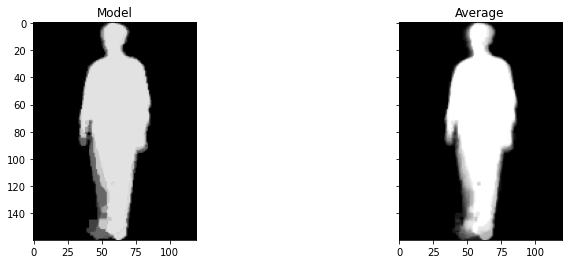

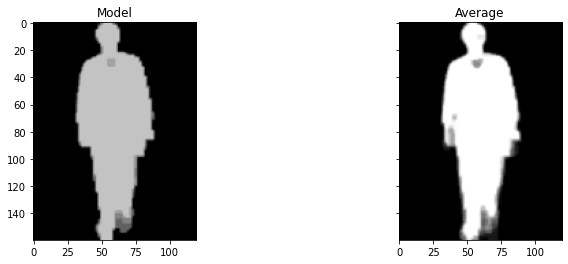

In [27]:

# type(axes)

for i,data in enumerate(train_dl):
    if i==5:
        break
    output = model(data[0].to(device=device))
    data[0] = data[0].reshape(data[0].shape[2],160,120)
    output = output.view(output.shape[2],160, 120)
    # print(output.shape)
    output = output.cpu().detach().numpy()
    output = np.mean(output,axis=0)
    ims(output,data[1].reshape(160,120))




### Check one sample

# TEST DATA: ANGLE 90, KEYPOSE 6

In [29]:
test_ds = Check(1,angle=90,keyposes=[6])

In [30]:
test_dl = DataLoader(test_ds,batch_size=1)

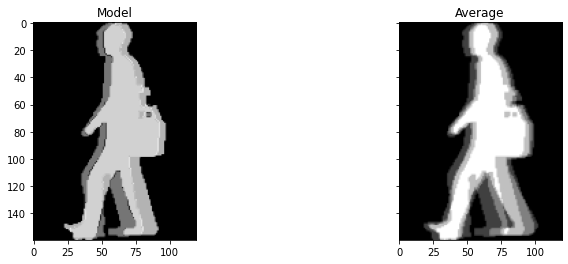

In [38]:
dataiter = iter(test_dl)
images, y = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
# print(type(images),images.shape)

#Sample outputs
output = model(images.to(device=device))
images = images.cpu().numpy().reshape(images.shape[2],160,120)
output = output.view(output.shape[2],160, 120)
output = output.cpu().detach().numpy()
output = np.mean(output,axis=0)

ims(output,y.view(160,120))

<ipython-input-39-a377d4ca0743>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


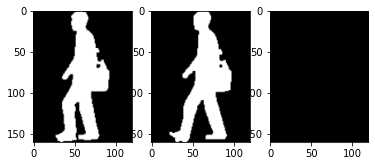

In [39]:
fig,ax = plt.subplots(nrows=1,ncols=3)
ax[0].imshow(images[0],cmap='gray')
ax[1].imshow(images[1],cmap='gray')
ax[2].imshow(images[2],cmap='gray')
fig.show()